In [2]:
import tensorflow.keras as k
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import numpy as np
from data_util import *

## Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = load_mnist()

x_train: (60000, 28, 28)
y_train: (60000, 10)
x_test: (10000, 28, 28)
y_test: (10000, 10)


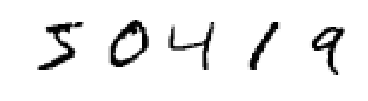

In [4]:
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
show_mnist(x_train[:5])

## Hyper parameters

In [6]:
input_shape = (28, 28)
batch_size = 128
epochs = 5

## Data Normalization

## Model with BN and unnormalized data

In [7]:
x_input = Input(shape=input_shape, name = "input")
x = Flatten()(x_input)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.3)(x)
x = Dense(10)(x)
output = Activation("sigmoid", name = "output")(x)

classifier_bn = Model(x_input, output, name= "nnclassifier")
classifier_bn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28)            0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
__________

## Compile and Training

In [8]:
classifier_bn.compile(loss = "categorical_crossentropy",
                  optimizer="adam",
                  metrics = ['accuracy'],
                  )

In [19]:
history = classifier_bn.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test,y_test),
                        )

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 1s 24us/step - loss: 0.0629 - acc: 0.9794 - val_loss: 0.0732 - val_acc: 0.9822


## Save Or load model

In [ ]:
classifier_bn.save('models/classifier_bn.h5')

In [7]:
classifier_bn = k.models.load_model("models/classifier_bn.h5")

## SAP noise

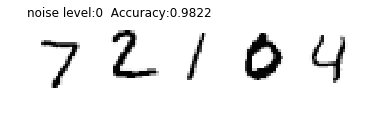

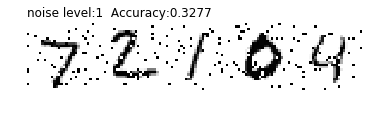

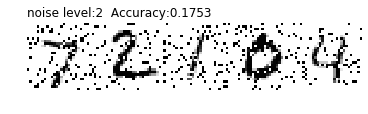

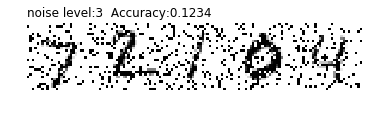

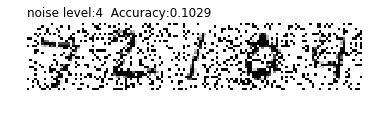

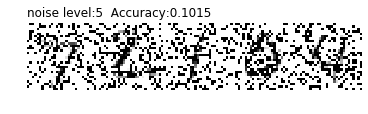

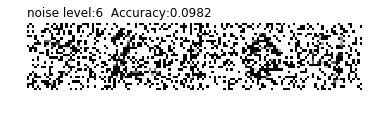

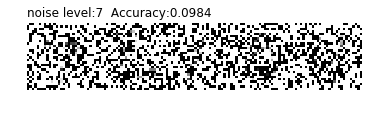

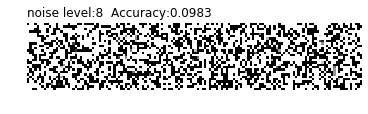

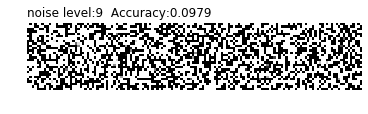

In [8]:
hist_sap = []
for level in range(10):
    noise_level = level / 10
    x_test_noisy = sap_noise(x_test, noise_level)
    hist = classifier_bn.evaluate(x_test_noisy,y_test, verbose=0)
    title = "noise level:" + str(level) + "  Accuracy:" + str(hist[1])
    show_mnist(x_test_noisy[:5], title=title, loc = "left")
    hist_sap.append(hist)

Text(0.5, 1.0, 'Predict with Gauusian Noise')

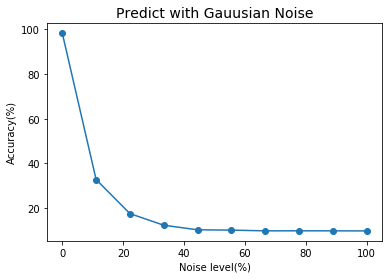

In [9]:
hist_sap= np.array(hist_sap)
plt.plot(np.linspace(0,100,num=10),hist_sap[:,1]*100, "-o")
plt.xlabel('Noise level(%)')
plt.ylabel('Accuracy(%)')
plt.title("Predict with Gauusian Noise", fontsize=14)

## Data Normalization

In [7]:
mean = x_train.mean()
std = x_train.std()

x_train = (x_train-mean) / std
x_test = (x_test - mean) / std

## Model without BN and unnormalized data

In [8]:
x_input = Input(shape=input_shape, name = "input")
x = Flatten()(x_input)
x = Dense(256)(x)
x = Activation("relu")(x)
# x = Dropout(0.5)(x)
x = Dense(10)(x)
output = Activation("sigmoid", name = "output")(x)

classifier = Model(x_input, output, name= "nnclassifier")
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28)            0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
_________________________________________________________________
output (Activation)          (None, 10)                0         
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


## Compile and Training

In [24]:
classifier.compile(loss = "categorical_crossentropy",
                  optimizer="adam",
                  metrics = ['accuracy'],
                  )

In [23]:
history = classifier.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=1,
                        verbose=1,
                        validation_data=(x_test,y_test),
                        )

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 1s 17us/step - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0666 - val_acc: 0.9837


## Save or Load  model

In [ ]:
classifier.save('models/classifier_without_bn.h5')

In [10]:
classifier = k.models.load_model("models/classifier_without_bn.h5")

## SAP noise

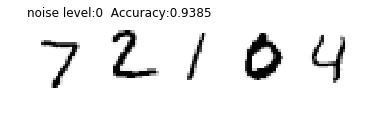

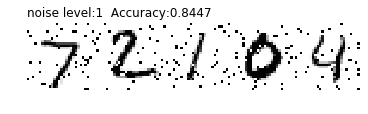

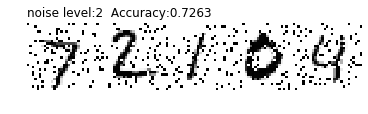

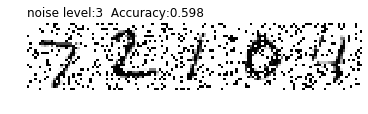

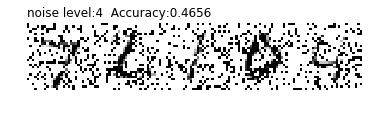

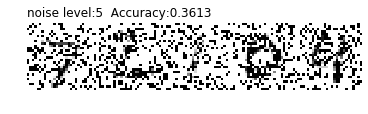

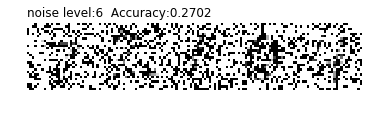

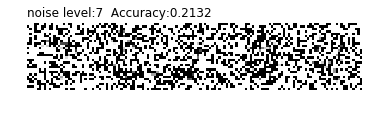

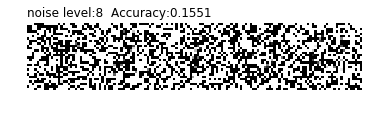

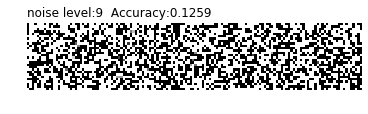

In [11]:
hist_sap = []
for level in range(10):
    noise_level = level / 10
    x_test_noisy = sap_noise(x_test, noise_level)
    hist = classifier.evaluate(x_test_noisy,y_test, verbose=0)
    title = "noise level:" + str(level) + "  Accuracy:" + str(hist[1])
    show_mnist(x_test_noisy[:5], title=title, loc = "left")
    hist_sap.append(hist)

Text(0.5, 1.0, 'Predict with Gauusian Noise')

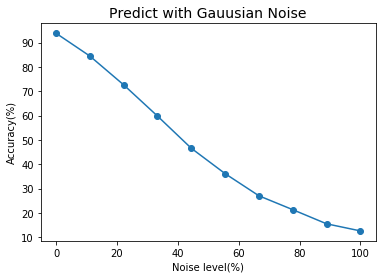

In [12]:
hist_sap= np.array(hist_sap)
plt.plot(np.linspace(0,100,num=10),hist_sap[:,1]*100, "-o")
plt.xlabel('Noise level(%)')
plt.ylabel('Accuracy(%)')
plt.title("Predict with Gauusian Noise", fontsize=14)

# Conclusion

- If your Model has BN layer then you dont have to normalize data before you train this model.
- With the noise level higher, the Accuracy of model with BN layers will descent rapidly.
- The model without BN layer and training with Normailized data is robuster with noise.

**Analyze**: The parameter of BN layer is learned from train data, and if add noise on train data, then the parameter of BN layer is not adapt for the new Noise data, so the Accuracy will be descent rapidly.